In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as dset
import pickle
from Metric import *

## 1. load cifar-10 data

In [99]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
# )
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

Files already downloaded and verified


## 2. prepare functions

In [2]:
def imshow(img):
    """
    show the img
    """
    img = img / 2 + 0.5
    npim = img.numpy() 
    plt.imshow(np.transpose(npim, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [3]:
def extract(label,num,dataloader):
  """
  extract imgs with given label
  """
  images_list = []
  dataiter = iter(dataloader)
  while len(images_list)<num:
    images, labels = next(dataiter)
    for i in range(4):
      if labels[i]==label:
        images_list.append(images[i])
  images_list = images_list[0:num]
  return images_list

In [4]:
from math import isnan
def cal_mean_MSSSIM(data, num):
  msssim = 0
  cnt = 0
  for i in range(len(data)-1):
    for j in range(i+1, len(data)):
      curr = get_ms_ssim(data[i].reshape(1,3,32,32),data[j].reshape(1,3,32,32))
      if not torch.isnan(curr).any():
        cnt += 1
        msssim += curr
        if cnt>=num: break
  msssim /= cnt
  return msssim


## 3. extract label 0-3 imgs and computes corresponding mean MS-SSIM

label 0: airplane

In [103]:
label_0_imgs = extract(0,1000,dataloader)
# with open('label_0_imgs.pickle', 'wb') as f:
#   pickle.dump(label_0_imgs, f)
# with open('data.pickle', 'rb') as f:
#   data = pickle.load(f)

In [113]:
mean_msssim_0 = cal_mean_MSSSIM(label_0_imgs,100)
print(mean_msssim_0)

tensor(0.0362)


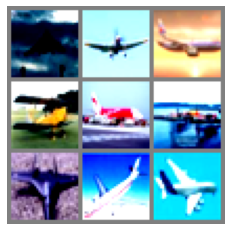

In [117]:
imshow(torchvision.utils.make_grid(label_0_imgs[100:109], nrow=3))

label 1: automobile

In [118]:
label_1_imgs = extract(1,1000,dataloader)

In [119]:
mean_msssim_1 = cal_mean_MSSSIM(label_1_imgs,100)
print(mean_msssim_1)

tensor(0.0347)


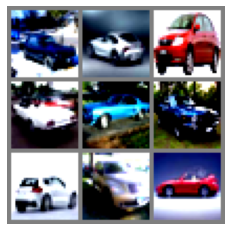

In [120]:
imshow(torchvision.utils.make_grid(label_1_imgs[100:109], nrow=3))

label 2: bird

In [121]:
label_2_imgs = extract(2,1000,dataloader)

In [122]:
mean_msssim_2 = cal_mean_MSSSIM(label_2_imgs,100)
print(mean_msssim_2)

tensor(0.0272)


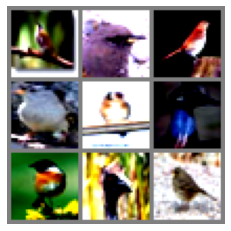

In [126]:
imshow(torchvision.utils.make_grid(label_2_imgs[0:9], nrow=3))

label 3: cat

In [127]:
label_3_imgs = extract(3,1000,dataloader)

In [128]:
mean_msssim_3 = cal_mean_MSSSIM(label_3_imgs,100)
print(mean_msssim_3)

tensor(0.0305)


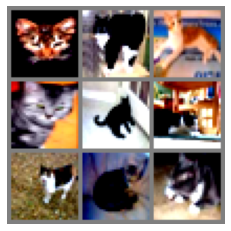

In [132]:
imshow(torchvision.utils.make_grid(label_3_imgs[130:139], nrow=3))

## 4. ACGAN generate images

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

Run on GPU...


In [33]:
from ACGAN import *
latent_dim = 100
num_classes = 10
def gen_imgs(label,batch_size):
  z = torch.randn(batch_size, latent_dim)
  gen_class = np.random.randint(label, label+1, batch_size)
  z_labels = torch.zeros(batch_size, num_classes)
  z_labels[np.arange(batch_size), gen_class] = 1.0
  z = torch.concat((z, z_labels), 1).to(device)
  gen_class = torch.from_numpy(gen_class).type(torch.LongTensor).to(device)

  generator = Generator(latent_dim + num_classes).to(device)
  generator.load_state_dict(torch.load('/content/generator.pth')) 
  gen_imgs = generator(z)
  return gen_imgs

label 0

In [40]:
label_0_gen = gen_imgs(0,200)

In [49]:
mean_msssim_gen_0 = cal_mean_MSSSIM(label_0_gen,100)
print(mean_msssim_gen_0.detach().cpu().numpy())

0.04151021


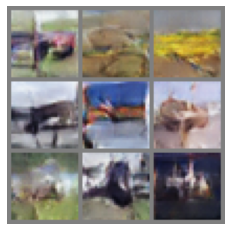

In [58]:
imshow(torchvision.utils.make_grid(label_0_gen[13:22].detach().cpu(), nrow=3))

label 1:

In [59]:
label_1_gen = gen_imgs(1,200)

In [60]:
mean_msssim_gen_1 = cal_mean_MSSSIM(label_1_gen,100)
print(mean_msssim_gen_1.detach().cpu().numpy())

0.06662781


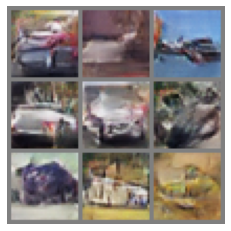

In [63]:
imshow(torchvision.utils.make_grid(label_1_gen[50:59].detach().cpu(), nrow=3))

label 2:

In [64]:
label_2_gen = gen_imgs(2,200)

In [65]:
mean_msssim_gen_2 = cal_mean_MSSSIM(label_2_gen,100)
print(mean_msssim_gen_2.detach().cpu().numpy())

0.044927064


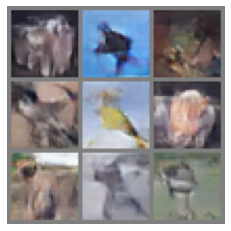

In [67]:
imshow(torchvision.utils.make_grid(label_2_gen[111:120].detach().cpu(), nrow=3))

label 3:

In [68]:
label_3_gen = gen_imgs(3,200)

In [69]:
mean_msssim_gen_3 = cal_mean_MSSSIM(label_3_gen,100)
print(mean_msssim_gen_3.detach().cpu().numpy())

0.026703589


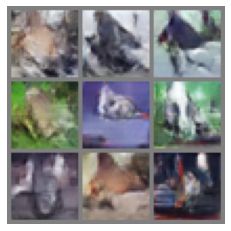

In [79]:
imshow(torchvision.utils.make_grid(label_3_gen[0:9].detach().cpu(), nrow=3))